In [1]:
##加载所需要的库
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba
import seaborn as sns
import re
from sklearn.model_selection import cross_val_score

#使用 sklearn 包中的 TfidfVectorizer 方法进行特征提取
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# 加载好评
Praise = pd.read_csv("./好评.csv",names=['ID','class','comment','star'])
# 加载差评
Negative_Ratings = pd.read_csv("./差评.csv",names=['ID','class','comment','star'])

###打印好评和差评形状
print("Praise.shape",Praise.shape)
print("Negative_Ratings.shape",Negative_Ratings.shape)

Praise.shape (55436, 4)
Negative_Ratings.shape (53379, 4)


In [3]:
# 对好评和差评去重
Praise = Praise.drop_duplicates()
Negative_Ratings = Negative_Ratings.drop_duplicates()

##去掉星级和评分不一致的行，即好评里去掉星级小于3的，差评里去掉星级大于三的
Negative_Ratings = Negative_Ratings[ Negative_Ratings['star'] <3]
Praise = Praise[Praise['star'] > 3]

# 将好评和差评放在同一个DataFrame中
Comment_collection = pd.concat([Praise,Negative_Ratings], ignore_index=True)
##打印合并后的评论集合
print("合并后的评论集合:", Comment_collection.shape)

##删除短评内容重复的行
Comment_collection = Comment_collection.drop_duplicates('comment')

##打印去除重复评论后的评论集合
print("去除重复评论后的评论集合:", Comment_collection.shape)

合并后的评论集合: (107450, 4)
去除重复评论后的评论集合: (104969, 4)


In [4]:
#根据短评星级，添加情绪标签，3星以上为1，3星以下为0
# 添加情绪标签
Comment_collection['emotion'] = (Comment_collection.star > 3) * 1

# 打乱顺序
Comment_collection = Comment_collection.sample(frac=1).reset_index(drop=True)
print("添加情绪标签:", Comment_collection.shape)

##统计情绪评级
print(Comment_collection['class'].value_counts())


添加情绪标签: (104969, 5)
好评    54296
差评    50673
Name: class, dtype: int64


In [5]:
##短评内容进行分词并去除停用词
def review_without_stop(review):
    # 打开停用词文件
    with open("./emotion_stopwords.txt","r",encoding="utf-8") as f:
        stop_word = [x.strip() for x in f.readlines()] 
    all_stop_words = set(stop_word) # 删除停用词中重复的项
    # 短评中的非中文字符替换为''
    review = re.sub("[^\u4e00-\u9fa5]",'',review)
    # 去除全角空白字符
    review = review.replace("\u3000","") 
    # 分词
    review = jieba.cut(review)
    # 过滤一个字的词
    review = filter(lambda x: len(x)>1,review)
    # 去除停用词
    review = filter(lambda x: x not in all_stop_words,review)
    return ' '.join(review)

# 自定义分词字典
jieba.load_userdict("./emotion_userdict.txt")
Comment_collection['cut_jieba'] = Comment_collection.comment.apply(review_without_stop)

#删除评论分词为空的行
# 去除停用词后，一些评论内容为空
print(Comment_collection[Comment_collection['cut_jieba'] == ''])

##选出去除停用词后不为空的
Comment_collection = Comment_collection[~(Comment_collection['cut_jieba'] == '')]
print("去除停用词后不为空的形状：",Comment_collection.shape)


# 差评中包含一些反问句，包含“好看”，“喜欢”，分词之后只剩余好看
print(Comment_collection[(Comment_collection['cut_jieba'] == '好看') & (Comment_collection['emotion'] == 0)])
print(Comment_collection[(Comment_collection['cut_jieba'] == '喜欢') & (Comment_collection['emotion'] == 0)])

Comment_collection = Comment_collection.drop(Comment_collection[(Comment_collection['cut_jieba'] == '好看') & (Comment_collection['emotion'] == 0)].index)
Comment_collection = Comment_collection.drop(Comment_collection[(Comment_collection['cut_jieba'] == '喜欢') & (Comment_collection['emotion'] == 0)].index)

print(Comment_collection.shape)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\张亦凡\AppData\Local\Temp\jieba.cache
Loading model cost 1.404 seconds.
Prefix dict has been built successfully.


              ID class                                            comment  \
10       1306861    好评  i think i know why it couldn't get an academy ...   
23      25954475    好评           https://movie.douban.com/review/7980263/   
88       3395373    好评                                        THE BATMAN！   
134      4848115    好评                                                 萌。   
150      1865703    差评                                            看不太懂啊哎哟   
...          ...   ...                                                ...   
104911   1299131    差评                                          已经开始有点烂了~   
104938   2209573    差评                          “I love you ”  “So what ”   
104948   1293460    差评                                               剧情好薄   
104951   1300374    好评  I'm tired, boss, tired of being on the road, l...   
104956   1303021    差评                                  不知道 这个不能不能演的更真一点！   

        star  emotion cut_jieba  
10         4        1            
23     

In [7]:
from sklearn.model_selection  import train_test_split

#建立训练数据集和测试数据集¶
X, y = Comment_collection['cut_jieba'], Comment_collection['emotion']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state = 10) 

tfidf_vect = TfidfVectorizer(decode_error='ignore',
                             token_pattern=r"\b[^\d\W]\w+\b", # 剔除向量化结果中的数字
                             analyzer='word',
                             ngram_range=(2,4),
                            max_df = 0.8,
                            min_df = 3)
Xtrain = tfidf_vect.fit_transform(x_train)
Xtest = tfidf_vect.transform(x_test)


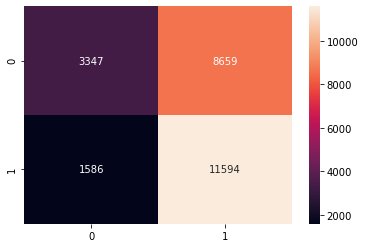

              precision    recall  f1-score   support

           0       0.68      0.28      0.40     12006
           1       0.57      0.88      0.69     13180

    accuracy                           0.59     25186
   macro avg       0.63      0.58      0.54     25186
weighted avg       0.62      0.59      0.55     25186

朴素贝叶斯测试集准确率为： 0.5932263956166124
朴素贝叶斯预测测试集准确率为： 0.6029752960379837


In [8]:
#用朴素贝叶斯完成中文文本分类器
from sklearn.naive_bayes import MultinomialNB
review_classifier = MultinomialNB()
review_classifier.fit(Xtrain,y_train)

# 对测试集的样本进行预测
y_pred = review_classifier.predict(Xtest)
confusion_matrix(y_test, y_pred) # 混淆矩阵

colorMetrics = confusion_matrix(y_test, y_pred)
sns.heatmap(colorMetrics,annot=True,fmt='d')
plt.show()

# 分类报告
# 给出每个类的准确率，召回率和F值，以及这三个参数
print(classification_report(y_test,y_pred)) 

print("朴素贝叶斯测试集准确率为：", accuracy_score(y_test, y_pred))
#k折交叉验证#
score1 = cross_val_score(review_classifier,Xtrain,y_train,cv=10,scoring="accuracy").mean()
print("朴素贝叶斯预测测试集准确率为：", score1)


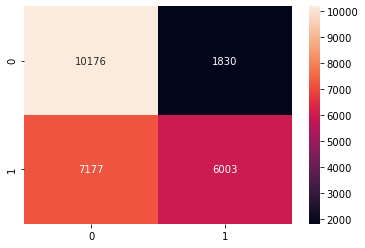

逻辑回归精确率、召回率、F1-score:
               precision    recall  f1-score   support

           0       0.59      0.85      0.69     12006
           1       0.77      0.46      0.57     13180

    accuracy                           0.64     25186
   macro avg       0.68      0.65      0.63     25186
weighted avg       0.68      0.64      0.63     25186

逻辑回归预测测试集准确率为： 0.6423806876836338
逻辑回归预测测试集准确率为： 0.6673371874298203


In [9]:
# 用逻辑回归完成中文文本分
from sklearn.linear_model import LogisticRegression  

LR_model = LogisticRegression(penalty='l2',max_iter=3000)  
LR_model.fit(Xtrain,y_train)

# 对测试集的样本进行预测
y_pred = LR_model.predict(Xtest)
confusion_matrix(y_test, y_pred) # 混淆矩阵

colorMetrics = confusion_matrix(y_test, y_pred)
sns.heatmap(colorMetrics,annot=True,fmt='d')
plt.show()

# 给出每个类的准确率，召回率和F值，以及这三个参数
print("逻辑回归精确率、召回率、F1-score:\n", classification_report(y_test, y_pred))

print("逻辑回归预测测试集准确率为：", LR_model.score(Xtest, y_test))
#k折交叉验证
score2 = cross_val_score(LR_model,Xtrain,y_train,cv=10,scoring="accuracy").mean()
print("逻辑回归预测测试集准确率为：", score2)

In [10]:
# 利用支持向量机（SVM）来做情感分析预测
from sklearn import svm

训练数据上的准确率为：0.7753748825390103
测试数据上的准确率为: 0.6395616612403716


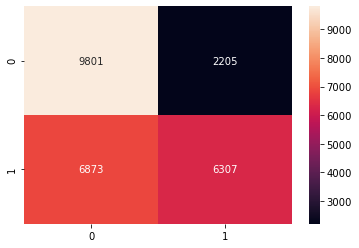

逻辑回归精确率、召回率、F1-score:
               precision    recall  f1-score   support

           0       0.59      0.82      0.68     12006
           1       0.74      0.48      0.58     13180

    accuracy                           0.64     25186
   macro avg       0.66      0.65      0.63     25186
weighted avg       0.67      0.64      0.63     25186

svm预测测试集准确率为： 0.66109014570755


In [11]:
# TODO: 初始化SVM模型，并利用模型的fit函数来做训练并打印在训练和测试数据上的准确率，SVM模型的kernel设置成“rbf”核函数
svc = svm.SVC(kernel='rbf').fit(Xtrain,y_train)
# 打印在训练数据上的准确率
print ("训练数据上的准确率为：" + str(svc.score(Xtrain, y_train)))
# 打印在测试数据上的准确率
print ("测试数据上的准确率为: " + str(svc.score(Xtest, y_test)))

y_pred = svc.predict(Xtest)
confusion_matrix(y_test, y_pred) # 混淆矩阵

colorMetrics = confusion_matrix(y_test, y_pred)
sns.heatmap(colorMetrics,annot=True,fmt='d')
plt.show()

# 给出每个类的准确率，召回率和F值，以及这三个参数
print("逻辑回归精确率、召回率、F1-score:\n", classification_report(y_test, y_pred))
score3 = cross_val_score(svc,Xtrain,y_train,cv=10,scoring="accuracy").mean()
print("svm预测测试集准确率为：", score3)

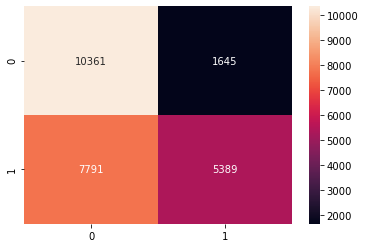

随机森林预测测试集准确率为： 0.6423806876836338
随机森林精确率、召回率、F1-score:
               precision    recall  f1-score   support

           0       0.57      0.86      0.69     12006
           1       0.77      0.41      0.53     13180

    accuracy                           0.63     25186
   macro avg       0.67      0.64      0.61     25186
weighted avg       0.67      0.63      0.61     25186

随机森林预测测试集准确率为： 0.6447979734987366


In [12]:
# 用随机森林完成中文文本分类
Clf_model = RandomForestClassifier()
Clf_model.fit(Xtrain, y_train)

# 对测试集的样本进行预测
y_pred = Clf_model.predict(Xtest)
confusion_matrix(y_test, y_pred)  # 混淆矩阵

colorMetrics = confusion_matrix(y_test, y_pred)
sns.heatmap(colorMetrics,annot=True,fmt='d')
plt.show()

print("随机森林预测测试集准确率为：", LR_model.score(Xtest, y_test))

# 给出每个类的准确率，召回率和F值，以及这三个参数
print("随机森林精确率、召回率、F1-score:\n", classification_report(y_test, y_pred))
score4 = cross_val_score(Clf_model,Xtrain,y_train,cv=10,scoring="accuracy").mean()
print("随机森林预测测试集准确率为：", score4)